## Work on real Merian image
Several updates:


In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import pickle
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [4]:
obj_cat = Table.read('./Cutout/magellan_spec/magellan_spec_obj_cat.fits')
cutout_cat = Table.read('./Cutout/magellan_spec/magellan_spec-2022-04-20.fits')

obj_cat['prefix'] = cutout_cat['prefix']
obj_cat['dir'] = cutout_cat['dir']
obj_cat['name'] = obj_cat['prefix']
obj_cat.write('./Catalogs/magellan/magellan_spec_obj_cat.fits', overwrite=True)

In [5]:
obj_cat = Table.read('./Catalogs/magellan/magellan_spec_obj_cat.fits')

### Step-by-step

165, 193, 201, 259, 286, 296, 312, 396,
        449, 484]),)

In [6]:
import sys
sys.path.append('/home/jiaxuanl/software/astrometry.net-0.89')
sys.path.append('/home/jiaxuanl/Research/Packages/tractor/')
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/')
from kuaizi.tractor.fit import tractor_hsc_sep_blob_by_blob
from kuaizi.tractor.utils import getTargetProperty

array([109, 162, 163, 252, 487, 488])

In [267]:
channels = list('grizy') + ['N708', 'N540']

obj = obj_cat[139]
obj_id = obj['id']

cutout = []
for filt in channels:
    if 'N' in filt:
        cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))
    else:
        cutout.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}.fits')))

psf_list = []
for filt in channels:
    if 'N' in filt:
        psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))
    else:
        psf_list.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}_psf.fits')))

# Reconstruct data
images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
hsc_data = Data(images=images,
                weights=weights,
                wcs=w, psfs=psf_pad, channels=channels)

Text(0.5, 1.0, 'Merian N708')

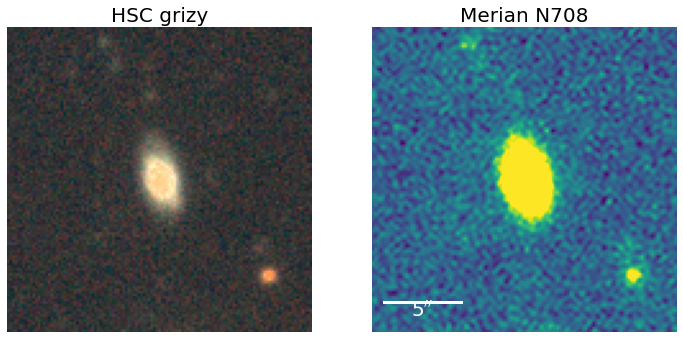

In [268]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(4)

img_rgb = scarlet.display.img_to_rgb(
    hsc_data.images[:4, ...],
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 12))

ax1.imshow(img_rgb, origin='lower', alpha=1)
ax1.axis('off')
ax1.set_title('HSC grizy', fontsize=20)

ax2 = display_single(hsc_data.images[-1], ax=ax2, pixel_scale=0.168)
ax2.axis('off')
ax2.set_title('Merian N708', fontsize=20)

### `magellan_spec_395245` i-band
    Detected 7 objects
# Total number of objects: 7
# Central object index in i-band: 1
# Progress: 1 / 7
# Progress: 2 / 7
# Progress: 3 / 7
# Progress: 4 / 7
# Progress: 5 / 7
# Progress: 6 / 7
# Progress: 7 / 7
# Global optimization: Chi2 improvement =  165.46927


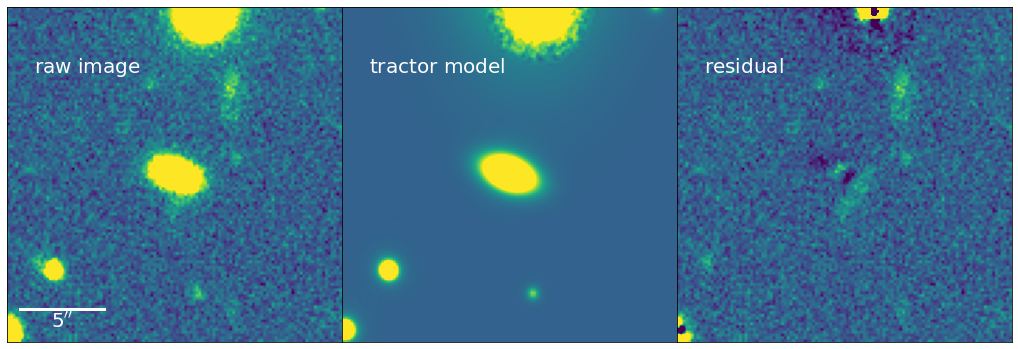

   The chi-square is 5.920282
ExpGalaxy at pixel (58.91, 59.31) with Flux: 251.327 and Galaxy Shape: re=0.85, ab=0.48, phi=69.5


In [9]:
# Start fitting
# fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands
model_dict = {}

ref_filt = 'i'
model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
    obj, ref_filt, hsc_data.channels, hsc_data, 
    freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
                 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
    verbose=True, show_fig=True)

### `magellan_spec_395245` g-band
# Total number of objects: 7
# Central object index in g-band: 1
# Global optimization: Chi2 improvement =  1888.7108


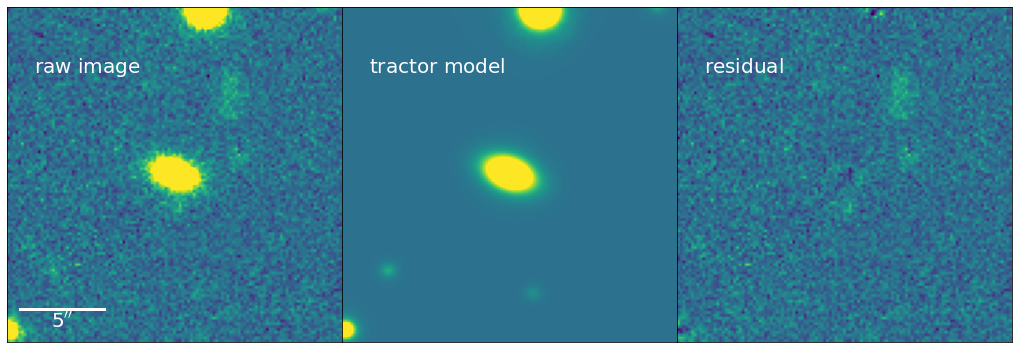

   The chi-square is 1.0367211
ExpGalaxy at pixel (58.95, 59.39) with Flux: 132.783 and Galaxy Shape: re=0.85, ab=0.48, phi=69.5


In [10]:
# Fix-all mode
model_dict['g'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'g', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True},  
    verbose=True, show_fig=True)

### `magellan_spec_395245` N708-band
# Total number of objects: 7
# Central object index in N708-band: 1
# Global optimization: Chi2 improvement =  407.0956


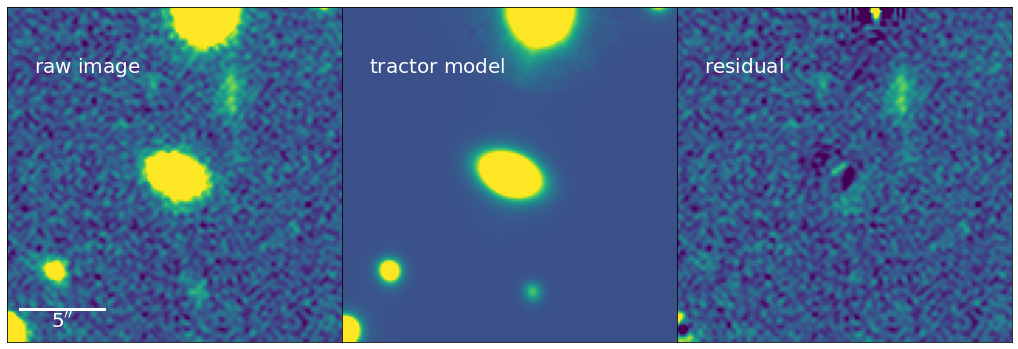

   The chi-square is 1.3711365
ExpGalaxy at pixel (59.19, 59.22) with Flux: 244.21 and Galaxy Shape: re=0.85, ab=0.48, phi=69.5


In [11]:
# Fix-all mode
model_dict['N708'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'N708', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
    # Since the coordinate system of Merian is different from HSC, we don't fix position. 
    verbose=True, show_fig=True)

In [22]:
-2.5 * np.log10(getTargetProperty(model_dict['g'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

0.861808241133562

In [57]:
obj['g_gaap_mag'] - obj['i_gaap_mag']

1.0991736691012974

In [23]:
2.5 * np.log10(getTargetProperty(model_dict['N708'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

-0.10841265966749469

In [59]:
(obj['i_gaap_mag'] - obj['N708_gaap_mag'])

-0.09449710511459841

# Batch fitting (forced-photometry, blob-by-blob)

In [14]:
from kuaizi.tractor.utils import initialize_meas_cat, _write_to_row, getTargetProperty

In [15]:
meas_cat = initialize_meas_cat(obj_cat)

### Tractor modeling for obj 0
### `magellan_spec_395729` i-band
    Detected 5 objects
# Total number of objects: 5
# Central object index in i-band: 0
# Progress: 1 / 5
# Progress: 2 / 5
# Progress: 3 / 5
# Progress: 4 / 5
# Progress: 5 / 5
# Global optimization: Chi2 improvement =  0.05560589


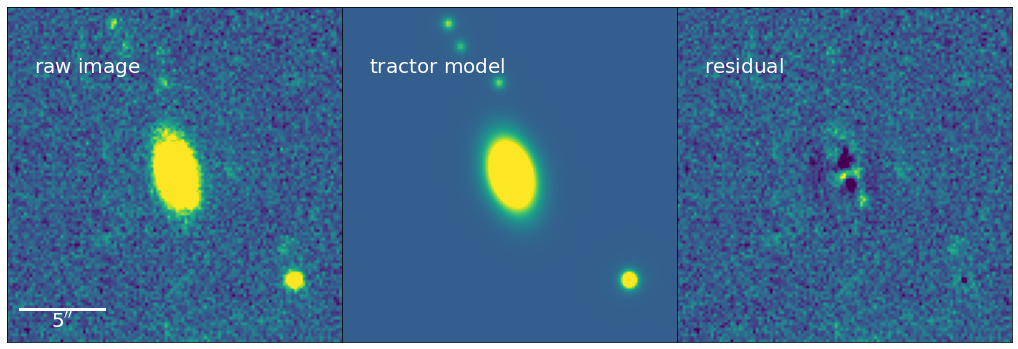

   The chi-square is 1.1429241
ExpGalaxy at pixel (59.68, 58.98) with Flux: 328.639 and Galaxy Shape: re=1.16, ab=0.55, phi=16.8
### `magellan_spec_395729` g-band
# Total number of objects: 5
# Central object index in g-band: 0
# Global optimization: Chi2 improvement =  3.1406722


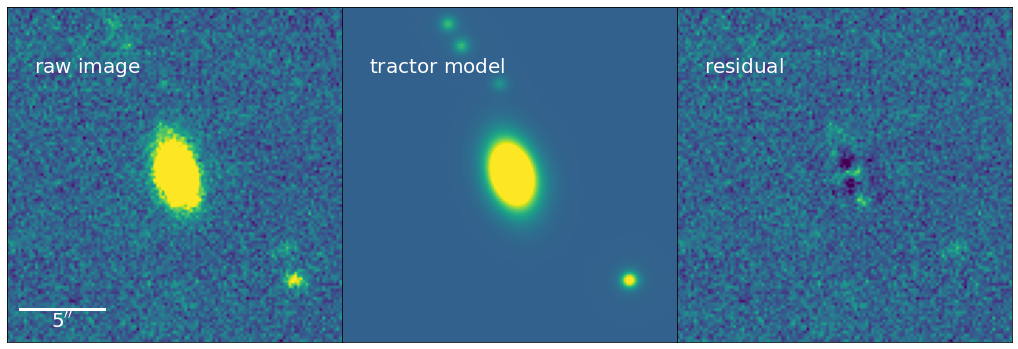

   The chi-square is 1.0952975
ExpGalaxy at pixel (59.82, 59.06) with Flux: 194.187 and Galaxy Shape: re=1.16, ab=0.55, phi=16.8
### `magellan_spec_395729` r-band
# Total number of objects: 5
# Central object index in r-band: 0
# Global optimization: Chi2 improvement =  0.3438704


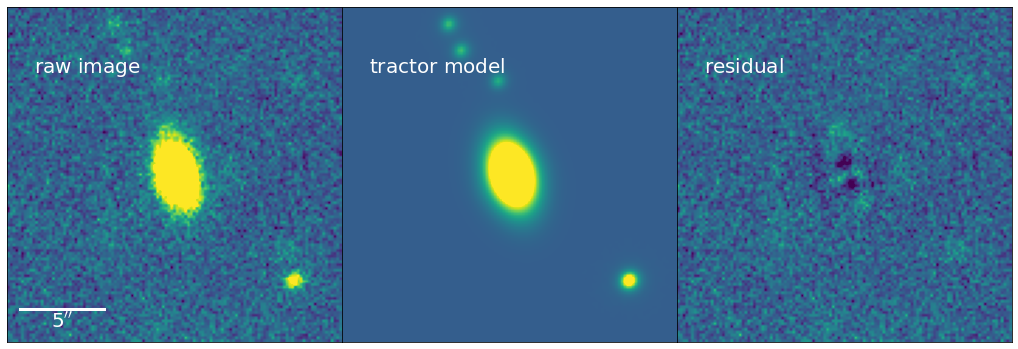

   The chi-square is 1.0943258
ExpGalaxy at pixel (59.77, 58.95) with Flux: 273.053 and Galaxy Shape: re=1.16, ab=0.55, phi=16.8
### `magellan_spec_395729` z-band
# Total number of objects: 5
# Central object index in z-band: 0
# Global optimization: Chi2 improvement =  0.037581205


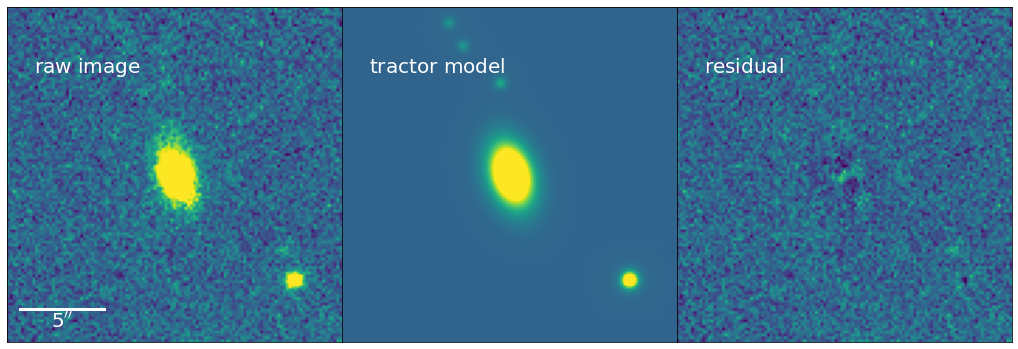

   The chi-square is 1.0564994
ExpGalaxy at pixel (59.66, 58.86) with Flux: 354.189 and Galaxy Shape: re=1.16, ab=0.55, phi=16.8
### `magellan_spec_395729` y-band
# Total number of objects: 5
# Central object index in y-band: 0
# Global optimization: Chi2 improvement =  0.030666828


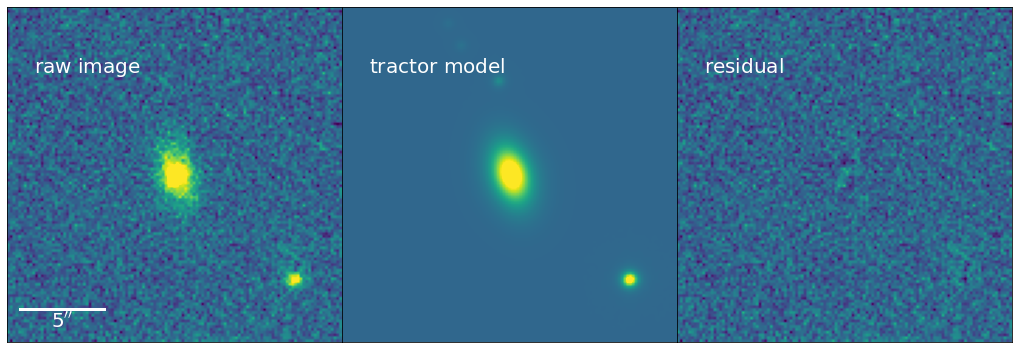

   The chi-square is 1.024689
ExpGalaxy at pixel (59.64, 58.97) with Flux: 379.819 and Galaxy Shape: re=1.16, ab=0.55, phi=16.8
### `magellan_spec_395729` N708-band
# Total number of objects: 5
# Central object index in N708-band: 0
# Global optimization: Chi2 improvement =  0.31866777


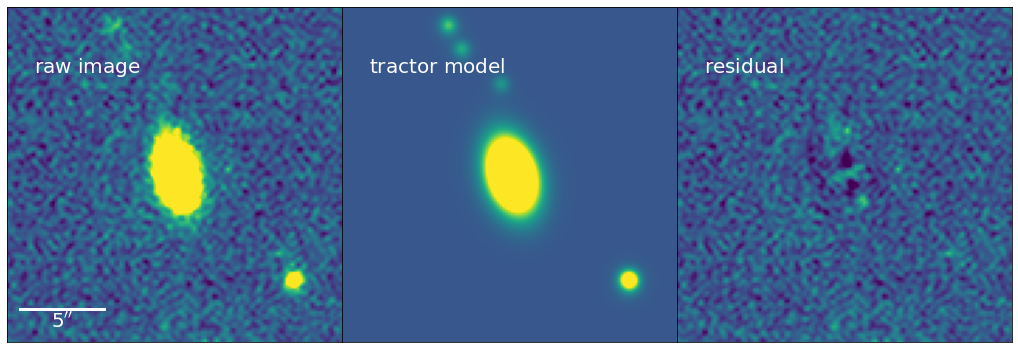

   The chi-square is 1.0686848
ExpGalaxy at pixel (59.91, 58.92) with Flux: 295.199 and Galaxy Shape: re=1.16, ab=0.55, phi=16.8
### `magellan_spec_395729` N540-band
# Total number of objects: 5
# Central object index in N540-band: 0
# Global optimization: Chi2 improvement =  3.2462263


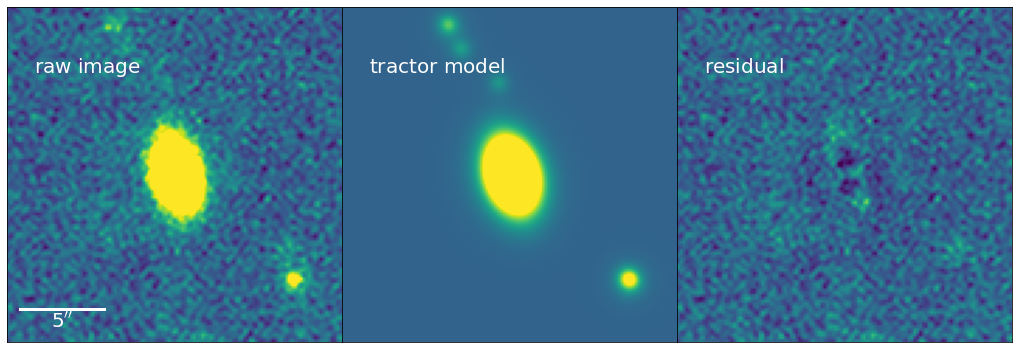

   The chi-square is 1.0685296
ExpGalaxy at pixel (59.96, 58.97) with Flux: 238.427 and Galaxy Shape: re=1.16, ab=0.55, phi=16.8


In [269]:
channels = list('grizy') + ['N708', 'N540']

ref_filt = 'i'
forced_channels = [filt for filt in channels if filt != ref_filt]

for k, obj in enumerate(obj_cat[139:139+1]):
    print(f'### Tractor modeling for obj {k}')
    obj_id = obj['id']
    
    cutout = []
    for filt in channels:
        if 'N' in filt:
            cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))
        else:
            cutout.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}.fits')))

    psf_list = []
    for filt in channels:
        if 'N' in filt:
            psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))
        else:
            psf_list.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}_psf.fits')))

    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    
    # Start fitting
    model_dict = {}
    # fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands 
    model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
        obj, ref_filt, data.channels, data, 
        freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
                     'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
        verbose=True, show_fig=True)
    
    for filt in forced_channels:
        pos = True
        fix_all = True
        ref_catalog = model_dict[ref_filt].catalog.copy()
        model_dict[filt], _ = tractor_hsc_sep_blob_by_blob(
            obj, filt, data.channels, data,
            fix_all=fix_all, tractor_cat=ref_catalog,
            obj_cat=_obj_cat_i,
            # ref_source=model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind],
            freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True,
                         'sersicindex': True},  # don't fix shape/sersic
            verbose=True, show_fig=True)
    with open(f'./cosmos_{obj["id"]}_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
    # Write to catalog
#     with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
#         pickle.dump(model_dict, f)

In [24]:
trac_obj = model_dict['i']

In [35]:
img = trac_obj.getModelImage(0, srcs=model_dict['i'].catalog[4:5])

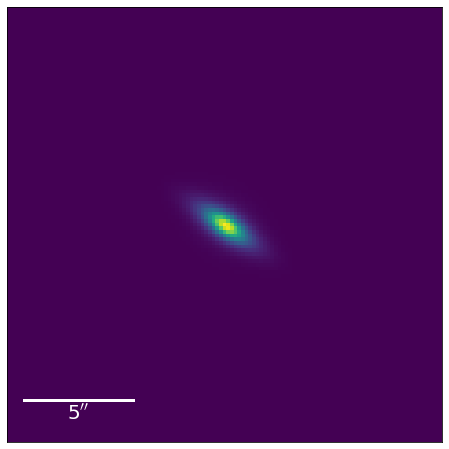

In [37]:
display_single(img, scale='linear');

---

In [61]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

In [62]:
suffix = 'magellan'

In [63]:
meas_cat = vstack([Table.read(f'./Catalogs/magellan/tractor_{suffix}_output_0_400.fits'),
                   Table.read(f'./Catalogs/magellan/tractor_{suffix}_output_400_759.fits'),
#                    Table.read(f'./Catalogs/magellan/tractor_{suffix}_output_600_759.fits')
                  ])
meas_cat['mag'] = 22.5 - 2.5 * np.log10(meas_cat['flux'].data)
flag = (meas_cat['flux'][:, 0] == 0.0) | (meas_cat['x_ivar'].data == 0)
print('Number of failures = ', np.sum(flag))
meas_cat['tractor_flag'] = flag
meas_cat.write(f'./Catalogs/magellan/tractor_{suffix}_output_all.fits', overwrite=True)
# obj_cat = Table.read(f'./Catalogs/COSMOS_cutouts_tractor_gaap_{suffix}.fits')
# obj_cat['dir'] = [file.replace('/projects/MERIAN/poststamps/g09_broadcut', 
#                               '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout'
#                              ) for file in obj_cat['dir']]
# meas_cat['ID_yifei'] = obj_cat['ID_yifei']

# meas_cat.sort('ID_yifei')
# obj_cat.sort('ID_yifei')

Number of failures =  2


In [162]:
from carpenter.display import display_merian_cutout_rgb

In [270]:
# Visualize our model
channels = list('griz') + ['N708', 'N540']
from kuaizi.tractor.utils import HiddenPrints
with HiddenPrints():
    model_img = np.asarray([
        model_dict[key].getModelImage(
            0, srcs=model_dict[key].catalog[model_dict[key].target_ind:model_dict[key].target_ind+1]
                                     ) for key in channels])

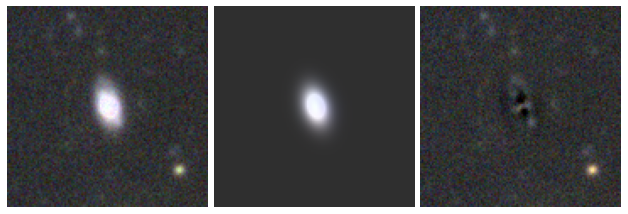

In [271]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(11, 5))

_img = np.vstack([data.images[0:4], data.images[-2:]])
_, img_rgb = display_merian_cutout_rgb(_img, filters=list('griz') + ['N708', 'N540'], 
                          ax=ax1, color_norm=None, Q=1.5, stretch=0.8, 
                          channel_map=None, N708_strength=3);

_, _ = display_merian_cutout_rgb(model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=ax2, Q=1.5, stretch=0.8, 
                                 color_norm=None,
                                 channel_map=None);

_, _ = display_merian_cutout_rgb(_img - model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=ax3, Q=1.5, stretch=0.8, 
                                       color_norm=None,
                                       channel_map=None);

plt.subplots_adjust(wspace=0.03)

In [291]:
### SBP

In [272]:
gal = model_dict['i'].catalog[model_dict['i'].target_ind]

In [273]:
gal.shape.re

1.1624791147456257

In [305]:
from photutils.isophote import EllipseGeometry
from photutils.isophote import Ellipse

geometry = EllipseGeometry(x0=gal.pos.x, 
                           y0=gal.pos.y, 
                           sma=gal.shape.re / 0.168, eps=1 - gal.shape.ab,
                           pa=(90 + gal.shape.phi) * np.pi / 180.)
ellipse = Ellipse(model_img[-2], geometry)
isolist1 = ellipse.fit_image(sma0=10, minsma=1, integrmode='median', 
                            fix_center=False, fix_pa=False, fix_eps=False)

_mean_eps = np.mean(isolist1.eps[isolist1.sma > 20])
_mean_pa = np.mean(isolist1.pa[isolist1.sma > 20])
_mean_x = np.mean(isolist1.x0[isolist1.sma > 20])
_mean_y = np.mean(isolist1.y0[isolist1.sma > 20])

In [306]:
print(gal.pos.x, gal.pos.y)
print((90 + gal.shape.phi) * np.pi / 180.)
print(_mean_x, _mean_y, _mean_eps, _mean_pa)

59.684372497202034 58.97933493596184
1.864055957341575
59.69994621977772 58.97957335350089 0.2627417814050305 1.835813547740053


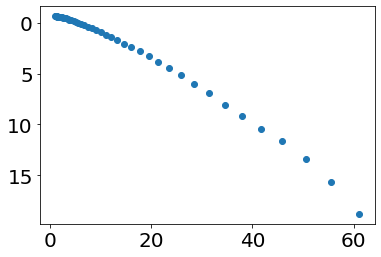

In [307]:
plt.scatter(isolist1.sma, -2.5*np.log10(isolist1.intens))

plt.gca().invert_yaxis()

    Detected 7 objects


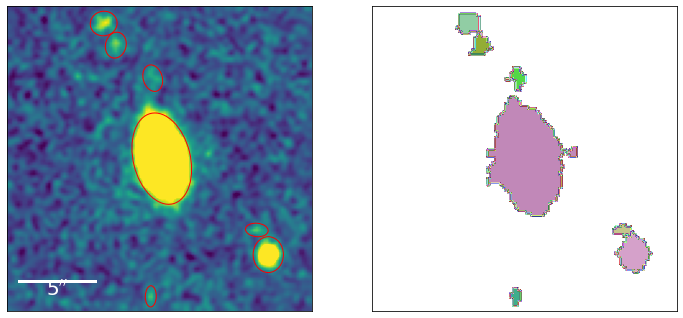

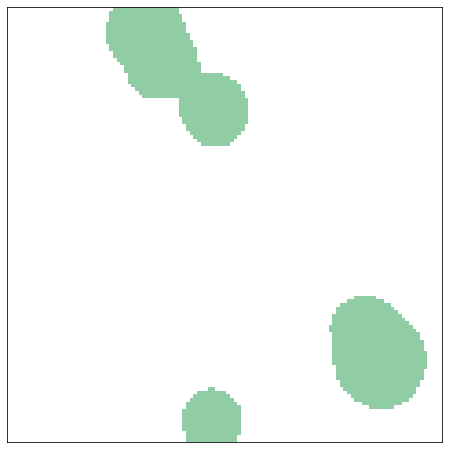

In [308]:
from kuaizi.detection import vanilla_detection
from astropy.convolution import convolve, Gaussian2DKernel
objcat, segmap, _ = vanilla_detection(data.images[-2], sigma=2, conv_radius=1, convolve=True)
cenid = segmap[segmap.shape[0] // 2, segmap.shape[1] // 2] - 1
segmap[segmap == (cenid + 1)] = 0.0

smooth_radius = 3
gaussian_threshold = 0.01
mask_conv = np.copy(segmap)
mask_conv[mask_conv > 0] = 1
mask_conv = convolve(mask_conv.astype(
    float), Gaussian2DKernel(smooth_radius))
mask = (mask_conv >= gaussian_threshold)

display_single(mask.astype(float), cmap=SEG_CMAP, scale='linear');

In [309]:
geometry = EllipseGeometry(x0=_mean_x, y0=_mean_y, 
                           sma=gal.shape.re / 0.168, eps=_mean_eps,
                           pa=_mean_pa)
ellipse = Ellipse(data.images[-2] * (~mask), geometry, threshold=0.001)
# ellipse = Ellipse(model_img[0] * (~mask), geometry, threshold=0.001)
# isolist = ellipse.fit_image(sma0=10, minsma=1, fix_center=False, fix_pa=False, fix_eps=False)

In [310]:
isolist = ellipse.fit_image(sma0=10, minsma=1, integrmode='median', nclip=3, 
                            maxgerr=1.,
                            fix_center=False, fix_eps=True, fix_pa=True)

In [311]:
isolist.sma

array([ 1.01525598,  1.11678158,  1.22845974,  1.35130571,  1.48643628,
        1.63507991,  1.7985879 ,  1.97844669,  2.17629136,  2.39392049,
        2.63331254,  2.8966438 ,  3.18630818,  3.50493899,  3.85543289,
        4.24097618,  4.6650738 ,  5.13158118,  5.6447393 ,  6.20921323,
        6.83013455,  7.51314801,  8.26446281,  9.09090909, 10.        ,
       11.        , 12.1       , 13.31      , 14.641     , 16.1051    ,
       17.71561   , 19.487171  , 21.4358881 , 23.57947691, 25.9374246 ])

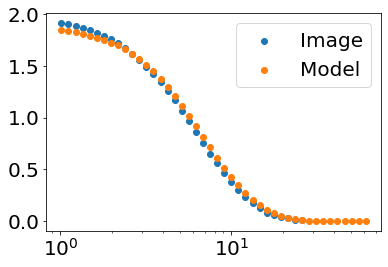

In [312]:
plt.scatter(isolist.sma, isolist.intens, label='Image')
plt.scatter(isolist1.sma, isolist1.intens, label='Model')
# plt.gca().invert_yaxis()

plt.xscale('log')
plt.legend()

(32.0, 21.0)

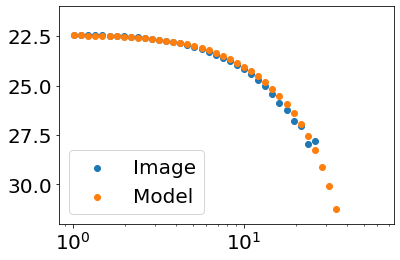

In [313]:
plt.scatter(isolist.sma, -2.5*np.log10(isolist.intens / 0.168**2) + 27, label='Image')
plt.scatter(isolist1.sma, -2.5*np.log10(isolist1.intens / 0.168**2) + 27, label='Model')
plt.gca().invert_yaxis()

plt.xscale('log')
plt.legend()

plt.ylim(32, 21)

In [132]:
isolist.sma

array([], dtype=float64)

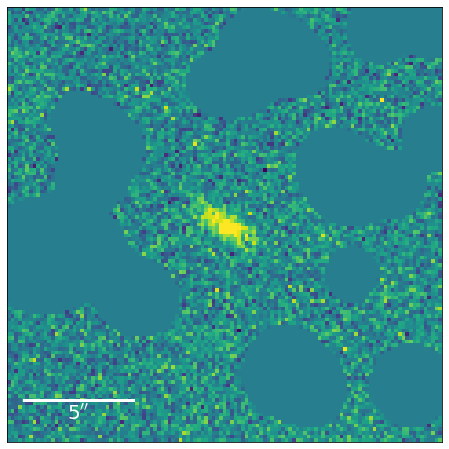

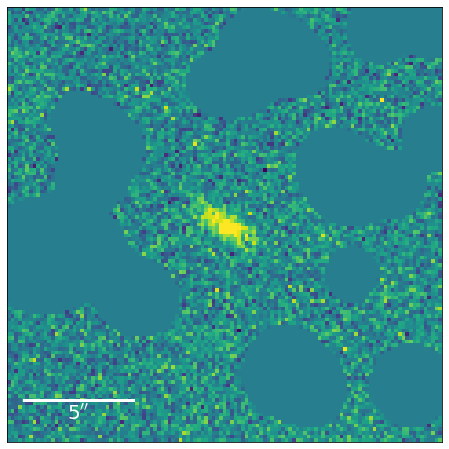

In [126]:
display_single(data.images[0] * (~mask))

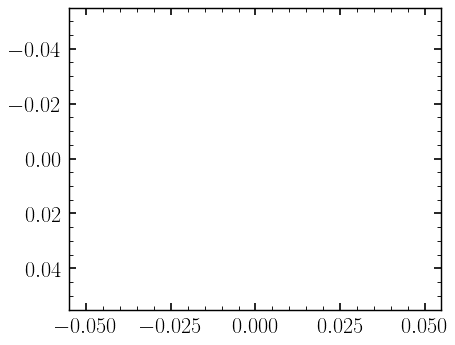

In [410]:
plt.scatter(isolist.sma, -2.5*np.log10(isolist.intens))

plt.gca().invert_yaxis()

In [381]:
from photutils.isophote import build_ellipse_model
_model = build_ellipse_model(hsc_data.images[0].shape, isolist)
# residual = data - model_image

In [385]:
trac_obj = model_dict['i']

In [388]:
trac_obj.catalog[0]

DevGalaxy(pos=PixPos[16.97346563225353, 52.67761186354045], brightness=Flux(109.84024980533633), shape=re=0.147961, ab=0.851048, phi=92.3959)

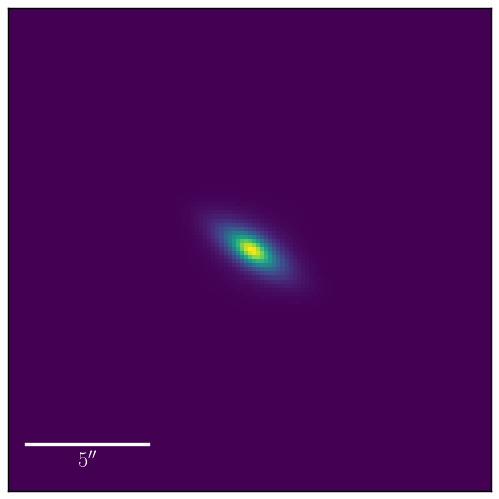

In [384]:
display_single(model_img[0], scale='linear');

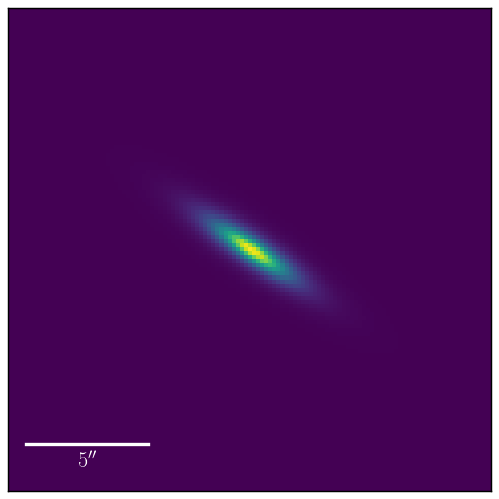

In [383]:
display_single( _model, scale='linear');

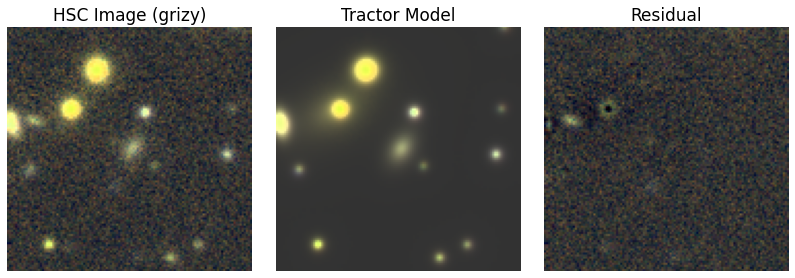

In [66]:
# ### Make figures into a PDF file (slow)
# from fpdf import FPDF
# pdf = FPDF()
# pdf.add_page()
# for k, image in enumerate([obj_name + '_sep_tractor_' + filt + '.png' for filt in channels]):
#     pdf.image(image, 21, 11 + k * 55, 167, 55)
# pdf.output(obj_name + "_sep_tractor.pdf", "F")

# Visualize our model
from kuaizi.tractor.utils import HiddenPrints
with HiddenPrints():
    model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

model_rgb = scarlet.display.img_to_rgb(
    model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

res_rgb = scarlet.display.img_to_rgb(
    data.images - model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
ax1.imshow(img_rgb, origin='lower')
ax2.imshow(model_rgb, origin='lower')
ax3.imshow(res_rgb, origin='lower')

for ax in [ax1, ax2, ax3]:
    ax.axis('off')

ax1.set_title('HSC Image (grizy)', fontsize=17)
ax2.set_title('Tractor Model', fontsize=17)
ax3.set_title('Residual', fontsize=17)

plt.subplots_adjust(wspace=0.1)
# plt.savefig(obj_name + '_sep_tractor_rgb.png', 
#             bbox_inches='tight', 
#             metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor + DECaLS catalog in each filter'})


#clear_output()
#plt.close()